In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 8
image_size = 64
nc = 3  # Number of channels (RGB)
nz = 128  # Latent vector size
n_steps = 1000  # Diffusion steps
lr = 0.0001  # Learning rate
text_embedding_dim = nz

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Diffusion Utilities
class DiffusionModel(nn.Module):
    def __init__(self, nc, nz):
        super(DiffusionModel, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(nc, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU()
        )

        self.up = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, nc, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x, t):
        h = self.down(x)
        h = self.middle(h)
        return self.up(h)

# Positional Embedding for Timestep
class PositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super(PositionalEmbedding, self).__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat((torch.sin(emb), torch.cos(emb)), dim=1)

# Noise Scheduler
class NoiseScheduler:
    def __init__(self, n_steps):
        self.n_steps = n_steps
        self.betas = torch.linspace(1e-4, 0.02, n_steps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def get_noise_level(self, t):
        return torch.sqrt(1 - self.alpha_cumprod[t])

    def add_noise(self, x, t):
        noise = torch.randn_like(x)
        alpha = torch.sqrt(self.alpha_cumprod[t])[:, None, None, None]
        beta = torch.sqrt(1 - self.alpha_cumprod[t])[:, None, None, None]
        return alpha * x + beta * noise, noise

In [ ]:
# Install the spaCy model
!python -m spacy download en_core_web_md


In [6]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        """
        root_dirs: A list of tuples (image_dir, text_dir, label)
        transform: Transformations to apply to the images
        """
        self.data = []
        self.transform = transform
        for image_dir, text_dir, label in root_dirs:
            image_files = os.listdir(image_dir)
            text_files = os.listdir(text_dir)
            # Ensure both images and text files match
            for img_file, txt_file in zip(image_files, text_files):
                self.data.append((os.path.join(image_dir, img_file), 
                                  os.path.join(text_dir, txt_file), 
                                  label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, text_path, label = self.data[idx]
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Load text
        with open(text_path, 'r') as file:
            description = file.read()
        return image, description, label


# Load spaCy model for text embeddings
nlp = spacy.load("en_core_web_md")

def encode_sentence(sentence):
    tokenized = nlp(sentence)
    word_embeddings = [token.vector for token in tokenized if token.is_alpha]
    if word_embeddings:
        return torch.tensor(np.mean(word_embeddings, axis=0), dtype=torch.float32)
    else:
        return torch.zeros(text_embedding_dim, dtype=torch.float32)

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Paths for both Sedans and SUVs
sedan_image_dir = "/kaggle/input/cars-dataset/cars_dataset/sedan_images"
sedan_text_dir = "/kaggle/input/cars-dataset/cars_dataset/sedan_names"
suv_image_dir = "/kaggle/input/cars-dataset/cars_dataset/suv_images"
suv_text_dir = "/kaggle/input/cars-dataset/cars_dataset/suv_names"

# Combine both datasets with class labels (0 for Sedan, 1 for SUV)
root_dirs = [
    (sedan_image_dir, sedan_text_dir, 0),  # Sedans
    (suv_image_dir, suv_text_dir, 1)      # SUVs
]

# Define dataset and dataloader
dataset = CustomDataset(root_dirs=root_dirs, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)



In [7]:
# Initialize model, optimizer, and loss
model = DiffusionModel(nc, nz).to(device)
positional_embedding = PositionalEmbedding(nz).to(device)
scheduler = NoiseScheduler(n_steps)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
# Debugging: Check sizes before training
for i, (images, descriptions, labels) in enumerate(dataloader):
    # Print the shapes of each component
    print(f"Batch {i}:")
    print(f"  Images Shape: {images.shape}")
    print(f"  Descriptions Count: {len(descriptions)}")
    print(f"  Labels Shape: {labels.shape if isinstance(labels, torch.Tensor) else 'Not a tensor'}")

    # Encode descriptions to check text embedding size
    text_embeddings = torch.stack([encode_sentence(desc) for desc in descriptions])
    print(f"  Text Embeddings Shape: {text_embeddings.shape}")
    
    # Check for mismatched sizes
    if text_embeddings.size(0) != labels.size(0) or text_embeddings.size(0) != images.size(0):
        print(f"  Mismatch detected! Text Embeddings: {text_embeddings.size(0)}, Labels: {labels.size(0)}, Images: {images.size(0)}")
        break  # Stop after detecting a mismatch for debugging


100%|██████████| 420/420 [00:37<00:00, 11.17it/s]


Epoch 1, Average Loss: 0.3625


100%|██████████| 420/420 [00:35<00:00, 11.91it/s]


Epoch 2, Average Loss: 0.3594


100%|██████████| 420/420 [00:34<00:00, 12.06it/s]


Epoch 3, Average Loss: 0.3613


100%|██████████| 420/420 [00:34<00:00, 12.14it/s]


Epoch 4, Average Loss: 0.3583


100%|██████████| 420/420 [00:34<00:00, 12.04it/s]


Epoch 5, Average Loss: 0.3611


100%|██████████| 420/420 [00:34<00:00, 12.03it/s]


Epoch 6, Average Loss: 0.3586


100%|██████████| 420/420 [00:35<00:00, 11.98it/s]


Epoch 7, Average Loss: 0.3601


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 8, Average Loss: 0.3577


100%|██████████| 420/420 [00:34<00:00, 12.10it/s]


Epoch 9, Average Loss: 0.3620


100%|██████████| 420/420 [00:34<00:00, 12.20it/s]


Epoch 10, Average Loss: 0.3595


100%|██████████| 420/420 [00:34<00:00, 12.35it/s]


Epoch 11, Average Loss: 0.3587


100%|██████████| 420/420 [00:34<00:00, 12.14it/s]


Epoch 12, Average Loss: 0.3593


100%|██████████| 420/420 [00:34<00:00, 12.34it/s]


Epoch 13, Average Loss: 0.3597


100%|██████████| 420/420 [00:34<00:00, 12.18it/s]


Epoch 14, Average Loss: 0.3595


100%|██████████| 420/420 [00:33<00:00, 12.37it/s]


Epoch 15, Average Loss: 0.3599


100%|██████████| 420/420 [00:33<00:00, 12.36it/s]


Epoch 16, Average Loss: 0.3599


100%|██████████| 420/420 [00:34<00:00, 12.24it/s]


Epoch 17, Average Loss: 0.3590


100%|██████████| 420/420 [00:33<00:00, 12.38it/s]


Epoch 18, Average Loss: 0.3594


100%|██████████| 420/420 [00:34<00:00, 12.25it/s]


Epoch 19, Average Loss: 0.3609


100%|██████████| 420/420 [00:33<00:00, 12.55it/s]


Epoch 20, Average Loss: 0.3583


100%|██████████| 420/420 [00:34<00:00, 12.26it/s]


Epoch 21, Average Loss: 0.3575


100%|██████████| 420/420 [00:33<00:00, 12.49it/s]


Epoch 22, Average Loss: 0.3574


100%|██████████| 420/420 [00:34<00:00, 12.33it/s]


Epoch 23, Average Loss: 0.3589


100%|██████████| 420/420 [00:34<00:00, 12.32it/s]


Epoch 24, Average Loss: 0.3590


100%|██████████| 420/420 [00:33<00:00, 12.42it/s]


Epoch 25, Average Loss: 0.3588


100%|██████████| 420/420 [00:33<00:00, 12.36it/s]


Epoch 26, Average Loss: 0.3588


100%|██████████| 420/420 [00:33<00:00, 12.51it/s]


Epoch 27, Average Loss: 0.3581


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 28, Average Loss: 0.3588


100%|██████████| 420/420 [00:33<00:00, 12.58it/s]


Epoch 29, Average Loss: 0.3574


100%|██████████| 420/420 [00:34<00:00, 12.31it/s]


Epoch 30, Average Loss: 0.3595


100%|██████████| 420/420 [00:33<00:00, 12.40it/s]


Epoch 31, Average Loss: 0.3575


100%|██████████| 420/420 [00:33<00:00, 12.41it/s]


Epoch 32, Average Loss: 0.3583


100%|██████████| 420/420 [00:34<00:00, 12.26it/s]


Epoch 33, Average Loss: 0.3546


100%|██████████| 420/420 [00:33<00:00, 12.40it/s]


Epoch 34, Average Loss: 0.3575


100%|██████████| 420/420 [00:34<00:00, 12.04it/s]


Epoch 35, Average Loss: 0.3581


100%|██████████| 420/420 [00:35<00:00, 11.82it/s]


Epoch 36, Average Loss: 0.3573


100%|██████████| 420/420 [00:36<00:00, 11.61it/s]


Epoch 37, Average Loss: 0.3553


100%|██████████| 420/420 [00:35<00:00, 11.80it/s]


Epoch 38, Average Loss: 0.3573


100%|██████████| 420/420 [00:34<00:00, 12.16it/s]


Epoch 39, Average Loss: 0.3590


100%|██████████| 420/420 [00:34<00:00, 12.25it/s]


Epoch 40, Average Loss: 0.3557


100%|██████████| 420/420 [00:33<00:00, 12.53it/s]


Epoch 41, Average Loss: 0.3573


100%|██████████| 420/420 [00:33<00:00, 12.38it/s]


Epoch 42, Average Loss: 0.3542


100%|██████████| 420/420 [00:33<00:00, 12.54it/s]


Epoch 43, Average Loss: 0.3539


100%|██████████| 420/420 [00:33<00:00, 12.40it/s]


Epoch 44, Average Loss: 0.3557


100%|██████████| 420/420 [00:34<00:00, 12.24it/s]


Epoch 45, Average Loss: 0.3543


100%|██████████| 420/420 [00:34<00:00, 12.31it/s]


Epoch 46, Average Loss: 0.3557


100%|██████████| 420/420 [00:34<00:00, 12.32it/s]


Epoch 47, Average Loss: 0.3555


100%|██████████| 420/420 [00:33<00:00, 12.58it/s]


Epoch 48, Average Loss: 0.3543


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 49, Average Loss: 0.3561


100%|██████████| 420/420 [00:33<00:00, 12.42it/s]


Epoch 50, Average Loss: 0.3554


100%|██████████| 420/420 [00:34<00:00, 12.22it/s]


Epoch 51, Average Loss: 0.3524


100%|██████████| 420/420 [00:34<00:00, 12.13it/s]


Epoch 52, Average Loss: 0.3528


100%|██████████| 420/420 [00:33<00:00, 12.44it/s]


Epoch 53, Average Loss: 0.3543


100%|██████████| 420/420 [00:34<00:00, 12.25it/s]


Epoch 54, Average Loss: 0.3546


100%|██████████| 420/420 [00:34<00:00, 12.26it/s]


Epoch 55, Average Loss: 0.3547


100%|██████████| 420/420 [00:34<00:00, 12.20it/s]


Epoch 56, Average Loss: 0.3549


100%|██████████| 420/420 [00:33<00:00, 12.46it/s]


Epoch 57, Average Loss: 0.3512


100%|██████████| 420/420 [00:34<00:00, 12.34it/s]


Epoch 58, Average Loss: 0.3537


100%|██████████| 420/420 [00:33<00:00, 12.37it/s]


Epoch 59, Average Loss: 0.3539


100%|██████████| 420/420 [00:34<00:00, 12.32it/s]


Epoch 60, Average Loss: 0.3531


100%|██████████| 420/420 [00:34<00:00, 12.33it/s]


Epoch 61, Average Loss: 0.3535


100%|██████████| 420/420 [00:33<00:00, 12.45it/s]


Epoch 62, Average Loss: 0.3527


100%|██████████| 420/420 [00:34<00:00, 12.34it/s]


Epoch 63, Average Loss: 0.3536


100%|██████████| 420/420 [00:33<00:00, 12.36it/s]


Epoch 64, Average Loss: 0.3534


100%|██████████| 420/420 [00:34<00:00, 12.16it/s]


Epoch 65, Average Loss: 0.3536


100%|██████████| 420/420 [00:34<00:00, 12.33it/s]


Epoch 66, Average Loss: 0.3537


100%|██████████| 420/420 [00:33<00:00, 12.40it/s]


Epoch 67, Average Loss: 0.3534


100%|██████████| 420/420 [00:33<00:00, 12.41it/s]


Epoch 68, Average Loss: 0.3518


100%|██████████| 420/420 [00:33<00:00, 12.54it/s]


Epoch 69, Average Loss: 0.3508


100%|██████████| 420/420 [00:33<00:00, 12.36it/s]


Epoch 70, Average Loss: 0.3546


100%|██████████| 420/420 [00:33<00:00, 12.46it/s]


Epoch 71, Average Loss: 0.3511


100%|██████████| 420/420 [00:34<00:00, 12.31it/s]


Epoch 72, Average Loss: 0.3543


100%|██████████| 420/420 [00:33<00:00, 12.46it/s]


Epoch 73, Average Loss: 0.3536


100%|██████████| 420/420 [00:33<00:00, 12.53it/s]


Epoch 74, Average Loss: 0.3501


100%|██████████| 420/420 [00:33<00:00, 12.39it/s]


Epoch 75, Average Loss: 0.3525


100%|██████████| 420/420 [00:33<00:00, 12.37it/s]


Epoch 76, Average Loss: 0.3519


100%|██████████| 420/420 [00:33<00:00, 12.42it/s]


Epoch 77, Average Loss: 0.3510


100%|██████████| 420/420 [00:33<00:00, 12.59it/s]


Epoch 78, Average Loss: 0.3489


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 79, Average Loss: 0.3509


100%|██████████| 420/420 [00:33<00:00, 12.42it/s]


Epoch 80, Average Loss: 0.3520


100%|██████████| 420/420 [00:34<00:00, 12.28it/s]


Epoch 81, Average Loss: 0.3501


100%|██████████| 420/420 [00:34<00:00, 12.20it/s]


Epoch 82, Average Loss: 0.3486


100%|██████████| 420/420 [00:33<00:00, 12.42it/s]


Epoch 83, Average Loss: 0.3508


100%|██████████| 420/420 [00:33<00:00, 12.36it/s]


Epoch 84, Average Loss: 0.3525


100%|██████████| 420/420 [00:33<00:00, 12.35it/s]


Epoch 85, Average Loss: 0.3517


100%|██████████| 420/420 [00:35<00:00, 12.00it/s]


Epoch 86, Average Loss: 0.3497


100%|██████████| 420/420 [00:34<00:00, 12.17it/s]


Epoch 87, Average Loss: 0.3527


100%|██████████| 420/420 [00:34<00:00, 12.25it/s]


Epoch 88, Average Loss: 0.3519


100%|██████████| 420/420 [00:33<00:00, 12.43it/s]


Epoch 89, Average Loss: 0.3518


100%|██████████| 420/420 [00:33<00:00, 12.40it/s]


Epoch 90, Average Loss: 0.3519


100%|██████████| 420/420 [00:34<00:00, 12.33it/s]


Epoch 91, Average Loss: 0.3505


100%|██████████| 420/420 [00:33<00:00, 12.38it/s]


Epoch 92, Average Loss: 0.3515


100%|██████████| 420/420 [00:34<00:00, 12.22it/s]


Epoch 93, Average Loss: 0.3498


100%|██████████| 420/420 [00:33<00:00, 12.51it/s]


Epoch 94, Average Loss: 0.3510


100%|██████████| 420/420 [00:34<00:00, 12.07it/s]


Epoch 95, Average Loss: 0.3506


100%|██████████| 420/420 [00:34<00:00, 12.25it/s]


Epoch 96, Average Loss: 0.3506


100%|██████████| 420/420 [00:34<00:00, 12.23it/s]


Epoch 97, Average Loss: 0.3497


100%|██████████| 420/420 [00:34<00:00, 12.19it/s]


Epoch 98, Average Loss: 0.3518


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 99, Average Loss: 0.3492


100%|██████████| 420/420 [00:35<00:00, 11.91it/s]


Epoch 100, Average Loss: 0.3509


100%|██████████| 420/420 [00:34<00:00, 12.22it/s]


Epoch 101, Average Loss: 0.3537


100%|██████████| 420/420 [00:36<00:00, 11.36it/s]


Epoch 102, Average Loss: 0.3495


100%|██████████| 420/420 [00:36<00:00, 11.43it/s]


Epoch 103, Average Loss: 0.3507


100%|██████████| 420/420 [00:37<00:00, 11.35it/s]


Epoch 104, Average Loss: 0.3491


100%|██████████| 420/420 [00:37<00:00, 11.28it/s]


Epoch 105, Average Loss: 0.3487


100%|██████████| 420/420 [00:36<00:00, 11.58it/s]


Epoch 106, Average Loss: 0.3477


100%|██████████| 420/420 [00:36<00:00, 11.52it/s]


Epoch 107, Average Loss: 0.3503


100%|██████████| 420/420 [00:36<00:00, 11.52it/s]


Epoch 108, Average Loss: 0.3523


100%|██████████| 420/420 [00:36<00:00, 11.65it/s]


Epoch 109, Average Loss: 0.3484


100%|██████████| 420/420 [00:35<00:00, 11.85it/s]


Epoch 110, Average Loss: 0.3476


100%|██████████| 420/420 [00:34<00:00, 12.11it/s]


Epoch 111, Average Loss: 0.3497


100%|██████████| 420/420 [00:34<00:00, 12.12it/s]


Epoch 112, Average Loss: 0.3502


100%|██████████| 420/420 [00:34<00:00, 12.19it/s]


Epoch 113, Average Loss: 0.3500


100%|██████████| 420/420 [00:34<00:00, 12.35it/s]


Epoch 114, Average Loss: 0.3482


100%|██████████| 420/420 [00:34<00:00, 12.16it/s]


Epoch 115, Average Loss: 0.3490


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 116, Average Loss: 0.3503


100%|██████████| 420/420 [00:35<00:00, 11.95it/s]


Epoch 117, Average Loss: 0.3478


100%|██████████| 420/420 [00:34<00:00, 12.21it/s]


Epoch 118, Average Loss: 0.3479


100%|██████████| 420/420 [00:34<00:00, 12.21it/s]


Epoch 119, Average Loss: 0.3467


100%|██████████| 420/420 [00:34<00:00, 12.26it/s]


Epoch 120, Average Loss: 0.3462


100%|██████████| 420/420 [00:34<00:00, 12.21it/s]


Epoch 121, Average Loss: 0.3502


100%|██████████| 420/420 [00:35<00:00, 11.78it/s]


Epoch 122, Average Loss: 0.3479


100%|██████████| 420/420 [00:33<00:00, 12.42it/s]


Epoch 123, Average Loss: 0.3477


100%|██████████| 420/420 [00:34<00:00, 12.07it/s]


Epoch 124, Average Loss: 0.3463


100%|██████████| 420/420 [00:34<00:00, 12.34it/s]


Epoch 125, Average Loss: 0.3484


100%|██████████| 420/420 [00:34<00:00, 12.33it/s]


Epoch 126, Average Loss: 0.3492


100%|██████████| 420/420 [00:34<00:00, 12.19it/s]


Epoch 127, Average Loss: 0.3478


100%|██████████| 420/420 [00:33<00:00, 12.35it/s]


Epoch 128, Average Loss: 0.3491


100%|██████████| 420/420 [00:34<00:00, 12.22it/s]


Epoch 129, Average Loss: 0.3469


100%|██████████| 420/420 [00:33<00:00, 12.37it/s]


Epoch 130, Average Loss: 0.3473


100%|██████████| 420/420 [00:34<00:00, 12.11it/s]


Epoch 131, Average Loss: 0.3455


100%|██████████| 420/420 [00:34<00:00, 12.12it/s]


Epoch 132, Average Loss: 0.3483


100%|██████████| 420/420 [00:34<00:00, 12.06it/s]


Epoch 133, Average Loss: 0.3479


100%|██████████| 420/420 [00:35<00:00, 11.99it/s]


Epoch 134, Average Loss: 0.3480


100%|██████████| 420/420 [00:34<00:00, 12.00it/s]


Epoch 135, Average Loss: 0.3475


100%|██████████| 420/420 [00:35<00:00, 11.91it/s]


Epoch 136, Average Loss: 0.3483


100%|██████████| 420/420 [00:34<00:00, 12.16it/s]


Epoch 137, Average Loss: 0.3496


100%|██████████| 420/420 [00:35<00:00, 11.98it/s]


Epoch 138, Average Loss: 0.3478


100%|██████████| 420/420 [00:35<00:00, 12.00it/s]


Epoch 139, Average Loss: 0.3479


100%|██████████| 420/420 [00:34<00:00, 12.03it/s]


Epoch 140, Average Loss: 0.3471


100%|██████████| 420/420 [00:35<00:00, 11.86it/s]


Epoch 141, Average Loss: 0.3465


100%|██████████| 420/420 [00:34<00:00, 12.31it/s]


Epoch 142, Average Loss: 0.3478


100%|██████████| 420/420 [00:34<00:00, 12.21it/s]


Epoch 143, Average Loss: 0.3474


100%|██████████| 420/420 [00:34<00:00, 12.31it/s]


Epoch 144, Average Loss: 0.3459


100%|██████████| 420/420 [00:34<00:00, 12.29it/s]


Epoch 145, Average Loss: 0.3483


100%|██████████| 420/420 [00:34<00:00, 12.06it/s]


Epoch 146, Average Loss: 0.3486


100%|██████████| 420/420 [00:34<00:00, 12.20it/s]


Epoch 147, Average Loss: 0.3468


100%|██████████| 420/420 [00:34<00:00, 12.16it/s]


Epoch 148, Average Loss: 0.3465


100%|██████████| 420/420 [00:34<00:00, 12.25it/s]


Epoch 149, Average Loss: 0.3489


100%|██████████| 420/420 [00:35<00:00, 11.96it/s]


Epoch 150, Average Loss: 0.3478


100%|██████████| 420/420 [00:35<00:00, 11.91it/s]


Epoch 151, Average Loss: 0.3464


100%|██████████| 420/420 [00:34<00:00, 12.09it/s]


Epoch 152, Average Loss: 0.3465


100%|██████████| 420/420 [00:35<00:00, 11.93it/s]


Epoch 153, Average Loss: 0.3438


100%|██████████| 420/420 [00:34<00:00, 12.26it/s]


Epoch 154, Average Loss: 0.3497


100%|██████████| 420/420 [00:34<00:00, 12.05it/s]


Epoch 155, Average Loss: 0.3472


100%|██████████| 420/420 [00:34<00:00, 12.15it/s]


Epoch 156, Average Loss: 0.3472


100%|██████████| 420/420 [00:34<00:00, 12.05it/s]


Epoch 157, Average Loss: 0.3466


100%|██████████| 420/420 [00:34<00:00, 12.22it/s]


Epoch 158, Average Loss: 0.3469


100%|██████████| 420/420 [00:34<00:00, 12.15it/s]


Epoch 159, Average Loss: 0.3456


100%|██████████| 420/420 [00:34<00:00, 12.10it/s]


Epoch 160, Average Loss: 0.3470


100%|██████████| 420/420 [00:34<00:00, 12.24it/s]


Epoch 161, Average Loss: 0.3456


100%|██████████| 420/420 [00:35<00:00, 11.85it/s]


Epoch 162, Average Loss: 0.3456


100%|██████████| 420/420 [00:34<00:00, 12.10it/s]


Epoch 163, Average Loss: 0.3476


100%|██████████| 420/420 [00:34<00:00, 12.28it/s]


Epoch 164, Average Loss: 0.3459


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 165, Average Loss: 0.3468


100%|██████████| 420/420 [00:33<00:00, 12.47it/s]


Epoch 166, Average Loss: 0.3484


100%|██████████| 420/420 [00:34<00:00, 12.26it/s]


Epoch 167, Average Loss: 0.3472


100%|██████████| 420/420 [00:33<00:00, 12.48it/s]


Epoch 168, Average Loss: 0.3480


100%|██████████| 420/420 [00:34<00:00, 12.23it/s]


Epoch 169, Average Loss: 0.3453


100%|██████████| 420/420 [00:33<00:00, 12.40it/s]


Epoch 170, Average Loss: 0.3457


100%|██████████| 420/420 [00:35<00:00, 11.99it/s]


Epoch 171, Average Loss: 0.3467


100%|██████████| 420/420 [00:34<00:00, 12.10it/s]


Epoch 172, Average Loss: 0.3458


100%|██████████| 420/420 [00:34<00:00, 12.24it/s]


Epoch 173, Average Loss: 0.3485


100%|██████████| 420/420 [00:34<00:00, 12.15it/s]


Epoch 174, Average Loss: 0.3504


100%|██████████| 420/420 [00:33<00:00, 12.53it/s]


Epoch 175, Average Loss: 0.3477


100%|██████████| 420/420 [00:34<00:00, 12.20it/s]


Epoch 176, Average Loss: 0.3461


100%|██████████| 420/420 [00:33<00:00, 12.43it/s]


Epoch 177, Average Loss: 0.3460


100%|██████████| 420/420 [00:33<00:00, 12.43it/s]


Epoch 178, Average Loss: 0.3464


100%|██████████| 420/420 [00:33<00:00, 12.45it/s]


Epoch 179, Average Loss: 0.3456


100%|██████████| 420/420 [00:33<00:00, 12.62it/s]


Epoch 180, Average Loss: 0.3448


100%|██████████| 420/420 [00:33<00:00, 12.45it/s]


Epoch 181, Average Loss: 0.3460


100%|██████████| 420/420 [00:33<00:00, 12.61it/s]


Epoch 182, Average Loss: 0.3489


100%|██████████| 420/420 [00:33<00:00, 12.46it/s]


Epoch 183, Average Loss: 0.3464


100%|██████████| 420/420 [00:33<00:00, 12.57it/s]


Epoch 184, Average Loss: 0.3482


100%|██████████| 420/420 [00:33<00:00, 12.42it/s]


Epoch 185, Average Loss: 0.3473


100%|██████████| 420/420 [00:33<00:00, 12.41it/s]


Epoch 186, Average Loss: 0.3460


100%|██████████| 420/420 [00:33<00:00, 12.46it/s]


Epoch 187, Average Loss: 0.3443


100%|██████████| 420/420 [00:33<00:00, 12.57it/s]


Epoch 188, Average Loss: 0.3443


100%|██████████| 420/420 [00:33<00:00, 12.52it/s]


Epoch 189, Average Loss: 0.3456


100%|██████████| 420/420 [00:34<00:00, 12.32it/s]


Epoch 190, Average Loss: 0.3443


100%|██████████| 420/420 [00:33<00:00, 12.60it/s]


Epoch 191, Average Loss: 0.3456


100%|██████████| 420/420 [00:33<00:00, 12.41it/s]


Epoch 192, Average Loss: 0.3469


100%|██████████| 420/420 [00:33<00:00, 12.66it/s]


Epoch 193, Average Loss: 0.3435


100%|██████████| 420/420 [00:34<00:00, 12.29it/s]


Epoch 194, Average Loss: 0.3446


100%|██████████| 420/420 [00:34<00:00, 12.25it/s]


Epoch 195, Average Loss: 0.3462


100%|██████████| 420/420 [00:34<00:00, 12.31it/s]


Epoch 196, Average Loss: 0.3439


100%|██████████| 420/420 [00:34<00:00, 12.28it/s]


Epoch 197, Average Loss: 0.3438


100%|██████████| 420/420 [00:33<00:00, 12.55it/s]


Epoch 198, Average Loss: 0.3429


100%|██████████| 420/420 [00:34<00:00, 12.31it/s]


Epoch 199, Average Loss: 0.3456


100%|██████████| 420/420 [00:33<00:00, 12.51it/s]


Epoch 200, Average Loss: 0.3439


100%|██████████| 420/420 [00:34<00:00, 12.23it/s]


Epoch 201, Average Loss: 0.3446


100%|██████████| 420/420 [00:33<00:00, 12.45it/s]


Epoch 202, Average Loss: 0.3472


100%|██████████| 420/420 [00:34<00:00, 12.35it/s]


Epoch 203, Average Loss: 0.3445


100%|██████████| 420/420 [00:33<00:00, 12.38it/s]


Epoch 204, Average Loss: 0.3456


100%|██████████| 420/420 [00:33<00:00, 12.48it/s]


Epoch 205, Average Loss: 0.3435


100%|██████████| 420/420 [00:34<00:00, 12.29it/s]


Epoch 206, Average Loss: 0.3476


100%|██████████| 420/420 [00:33<00:00, 12.49it/s]


Epoch 207, Average Loss: 0.3450


100%|██████████| 420/420 [00:34<00:00, 12.07it/s]


Epoch 208, Average Loss: 0.3444


100%|██████████| 420/420 [00:33<00:00, 12.56it/s]


Epoch 209, Average Loss: 0.3467


100%|██████████| 420/420 [00:34<00:00, 12.26it/s]


Epoch 210, Average Loss: 0.3440


100%|██████████| 420/420 [00:33<00:00, 12.39it/s]


Epoch 211, Average Loss: 0.3427


100%|██████████| 420/420 [00:33<00:00, 12.42it/s]


Epoch 212, Average Loss: 0.3455


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 213, Average Loss: 0.3451


100%|██████████| 420/420 [00:33<00:00, 12.52it/s]


Epoch 214, Average Loss: 0.3428


100%|██████████| 420/420 [00:34<00:00, 12.32it/s]


Epoch 215, Average Loss: 0.3441


100%|██████████| 420/420 [00:33<00:00, 12.53it/s]


Epoch 216, Average Loss: 0.3441


100%|██████████| 420/420 [00:34<00:00, 12.35it/s]


Epoch 217, Average Loss: 0.3440


100%|██████████| 420/420 [00:33<00:00, 12.37it/s]


Epoch 218, Average Loss: 0.3435


100%|██████████| 420/420 [00:33<00:00, 12.40it/s]


Epoch 219, Average Loss: 0.3430


100%|██████████| 420/420 [00:33<00:00, 12.38it/s]


Epoch 220, Average Loss: 0.3436


100%|██████████| 420/420 [00:33<00:00, 12.53it/s]


Epoch 221, Average Loss: 0.3442


100%|██████████| 420/420 [00:33<00:00, 12.36it/s]


Epoch 222, Average Loss: 0.3424


100%|██████████| 420/420 [00:33<00:00, 12.49it/s]


Epoch 223, Average Loss: 0.3441


100%|██████████| 420/420 [00:34<00:00, 12.05it/s]


Epoch 224, Average Loss: 0.3438


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 225, Average Loss: 0.3431


100%|██████████| 420/420 [00:33<00:00, 12.42it/s]


Epoch 226, Average Loss: 0.3455


100%|██████████| 420/420 [00:34<00:00, 12.28it/s]


Epoch 227, Average Loss: 0.3430


100%|██████████| 420/420 [00:33<00:00, 12.49it/s]


Epoch 228, Average Loss: 0.3422


100%|██████████| 420/420 [00:34<00:00, 12.20it/s]


Epoch 229, Average Loss: 0.3435


100%|██████████| 420/420 [00:33<00:00, 12.44it/s]


Epoch 230, Average Loss: 0.3426


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 231, Average Loss: 0.3436


100%|██████████| 420/420 [00:34<00:00, 12.32it/s]


Epoch 232, Average Loss: 0.3435


100%|██████████| 420/420 [00:34<00:00, 12.33it/s]


Epoch 233, Average Loss: 0.3438


100%|██████████| 420/420 [00:34<00:00, 12.22it/s]


Epoch 234, Average Loss: 0.3433


100%|██████████| 420/420 [00:34<00:00, 12.27it/s]


Epoch 235, Average Loss: 0.3423


100%|██████████| 420/420 [00:34<00:00, 12.10it/s]


Epoch 236, Average Loss: 0.3436


100%|██████████| 420/420 [00:33<00:00, 12.40it/s]


Epoch 237, Average Loss: 0.3414


100%|██████████| 420/420 [00:34<00:00, 12.12it/s]


Epoch 238, Average Loss: 0.3424


100%|██████████| 420/420 [00:34<00:00, 12.21it/s]


Epoch 239, Average Loss: 0.3433


100%|██████████| 420/420 [00:34<00:00, 12.19it/s]


Epoch 240, Average Loss: 0.3408


100%|██████████| 420/420 [00:34<00:00, 12.24it/s]


Epoch 241, Average Loss: 0.3410


100%|██████████| 420/420 [00:34<00:00, 12.32it/s]


Epoch 242, Average Loss: 0.3412


100%|██████████| 420/420 [00:34<00:00, 12.06it/s]


Epoch 243, Average Loss: 0.3425


100%|██████████| 420/420 [00:33<00:00, 12.41it/s]


Epoch 244, Average Loss: 0.3409


100%|██████████| 420/420 [00:34<00:00, 12.17it/s]


Epoch 245, Average Loss: 0.3406


100%|██████████| 420/420 [00:34<00:00, 12.30it/s]


Epoch 246, Average Loss: 0.3425


100%|██████████| 420/420 [00:34<00:00, 12.19it/s]


Epoch 247, Average Loss: 0.3415


100%|██████████| 420/420 [00:34<00:00, 12.29it/s]


Epoch 248, Average Loss: 0.3427


100%|██████████| 420/420 [00:34<00:00, 12.26it/s]


Epoch 249, Average Loss: 0.3418


100%|██████████| 420/420 [00:34<00:00, 12.03it/s]


Epoch 250, Average Loss: 0.3431


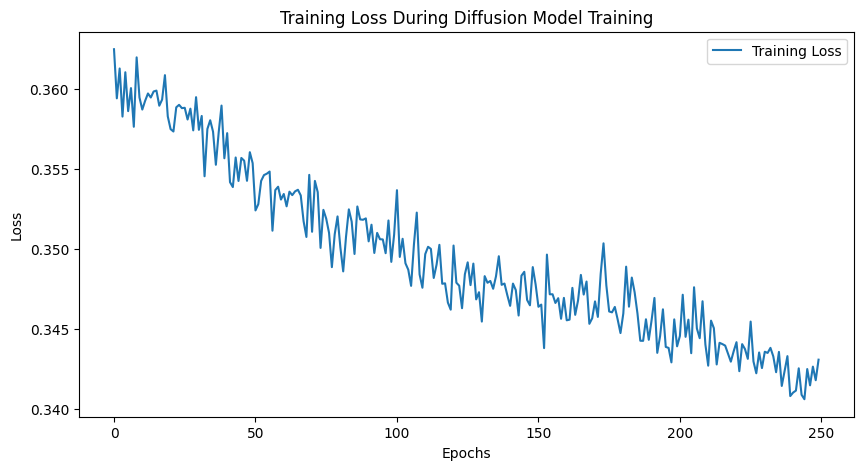

In [15]:
# Initialize lists to store losses
losses = []

# Training Loop
for epoch in range(250):  # Number of epochs
    epoch_loss = 0
    model.train()  # Ensure the model is in training mode
    for images, descriptions, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        batch_size = images.size(0)

        # Random timesteps for diffusion
        t = torch.randint(0, n_steps, (batch_size,), device=device)
        # Encode text descriptions
        text_embeddings = torch.stack([encode_sentence(desc).to(device) for desc in descriptions])
        
        # Project or adjust embeddings to match `nz`
        if text_embeddings.size(1) != nz:
            text_embeddings = text_embeddings[:, :nz] if text_embeddings.size(1) > nz else torch.cat(
                [text_embeddings, torch.zeros((text_embeddings.size(0), nz - text_embeddings.size(1)), device=device)], dim=1
            )

        
        # Debugging the shape of text embeddings
        #print(f"Text Embedding Shape: {text_embeddings.shape}")
        
        # Concatenate text embeddings and labels (optional)
        conditional_embeddings = torch.cat([text_embeddings, labels], dim=1)

        # Add noise to images
        noised_images, noise = scheduler.add_noise(images, t)
        
        # Debugging the shape of noise
        #print(f"Noise Shape: {noise.shape}, Noised Images Shape: {noised_images.shape}")

        optimizer.zero_grad()

        # Forward pass
        predictions = model(noised_images, positional_embedding(t))

        # Compute loss
        loss = criterion(predictions, noise)
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Compute average loss for the epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    losses.append(avg_epoch_loss)

    print(f"Epoch {epoch + 1}, Average Loss: {avg_epoch_loss:.4f}")

# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.title("Training Loss During Diffusion Model Training")
plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
model_save_dir = '/kaggle/working/models'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

torch.save(model.state_dict(), os.path.join(model_save_dir, 'diffusion_model.pth'))
print(f"Final model saved to: {model_save_dir}")

Final model saved to: /kaggle/working/models


Generating images for: 'a red sedan car'
 Text Embedding Shape: torch.Size([128])
Initial Noise Shape: torch.Size([1, 3, 64, 64])


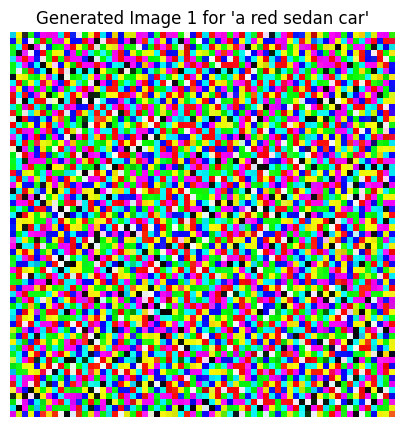

Generating images for: 'a black SUV'
 Text Embedding Shape: torch.Size([128])
Initial Noise Shape: torch.Size([1, 3, 64, 64])


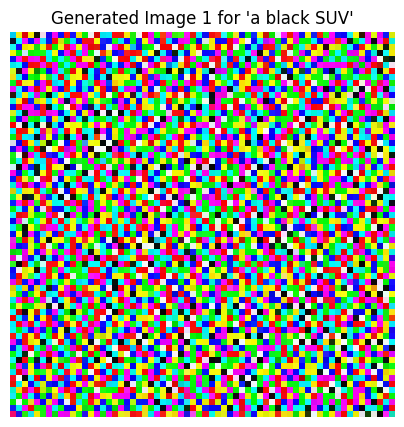

Generating images for: 'a white sedan car'
 Text Embedding Shape: torch.Size([128])
Initial Noise Shape: torch.Size([1, 3, 64, 64])


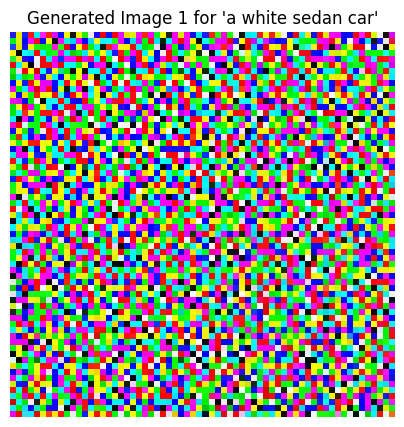

Generating images for: 'a yellow sedan'
 Text Embedding Shape: torch.Size([128])
Initial Noise Shape: torch.Size([1, 3, 64, 64])


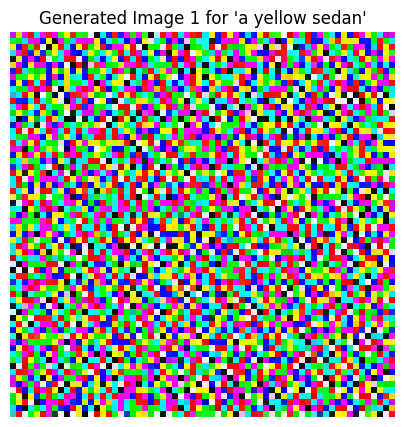

Generating images for: 'a white SUV'
 Text Embedding Shape: torch.Size([128])
Initial Noise Shape: torch.Size([1, 3, 64, 64])


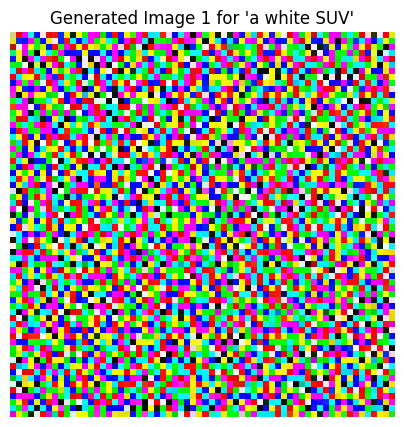

Generating images for: 'a silver SUV'
 Text Embedding Shape: torch.Size([128])
Initial Noise Shape: torch.Size([1, 3, 64, 64])


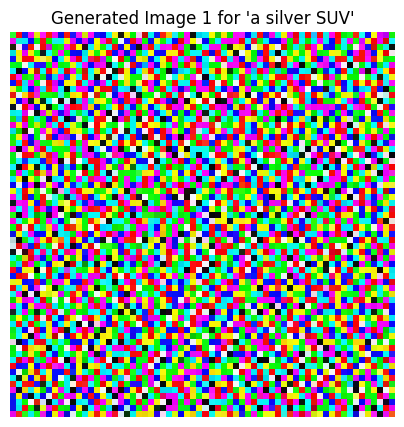

In [17]:
# Image Generation with Diagnostics
def generate_images(descriptions, num_images=1):
    model.eval()  # Set the model to evaluation mode
    for description in descriptions:
        print(f"Generating images for: '{description}'")
        
        # Encode the text description
        text_embedding = encode_sentence(description).to(device)
        #print(f"Original Text Embedding Shape: {text_embedding.shape}")

        # Align text embedding to match nz
        if text_embedding.size(0) != nz:
            text_embedding = text_embedding[:nz] if text_embedding.size(0) > nz else torch.cat(
                [text_embedding, torch.zeros(nz - text_embedding.size(0), device=device)]
            )
        print(f" Text Embedding Shape: {text_embedding.shape}")

        for img_num in range(num_images):
            # Start with random noise
            noise = torch.randn(1, nc, image_size, image_size, device=device)
            print(f"Initial Noise Shape: {noise.shape}")

            # Reverse diffusion process
            for t in range(n_steps - 1, -1, -1):
                with torch.no_grad():
                    noise = model(noise, positional_embedding(torch.tensor([t], device=device)))

            # Normalize and display the generated image
            generated_image = (noise.squeeze(0).permute(1, 2, 0).cpu().numpy() + 1) / 2
            generated_image = np.clip(generated_image, 0, 1)  # Clamp values to [0, 1]
            plt.figure(figsize=(5, 5))
            plt.imshow(generated_image)
            plt.axis('off')
            plt.title(f"Generated Image {img_num + 1} for '{description}'")
            plt.show()



# Example Test Cases
descriptions = [
    "a red sedan car",
    "a black SUV",
    "a white sedan car",
    "a yellow sedan",
    "a white SUV",
    "a silver SUV"
]

# Generate 2 images per description
generate_images(descriptions, num_images=1)


# Model weights

model link - https://drive.google.com/file/d/1JPt6cm33r-m8B4J5RtCZqWD5weRv_fkx/view?usp=sharing